In [11]:
# Importing necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Data Preparation
data = pd.read_csv('creditcard.csv')

# Remove unnecessary columns
data = data.drop(['Time'], axis=1)

# Standardize the features
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Split the data into normal and fraudulent
normal_data = data[data['Class'] == 0]
fraudulent_data = data[data['Class'] == 1]

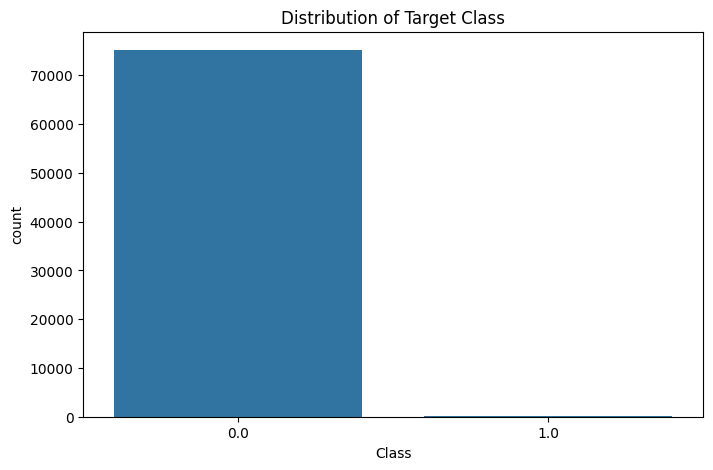

In [13]:
# Distribution of the target class
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=data)
plt.title('Distribution of Target Class')
plt.show()

In [14]:
# Exploratory Data Analysis (EDA)
print("Basic Statistics of the Dataset:")
print(data.describe())

Basic Statistics of the Dataset:
                 V1            V2            V3            V4            V5  \
count  75357.000000  75357.000000  75357.000000  75357.000000  75357.000000   
mean      -0.252779     -0.028574      0.678975      0.166227     -0.274493   
std        1.877372      1.660941      1.402475      1.370891      1.387110   
min      -56.407510    -72.715728    -33.680984     -5.172595    -42.147898   
25%       -1.014563     -0.595725      0.190522     -0.725740     -0.891744   
50%       -0.246462      0.070645      0.766814      0.185626     -0.306681   
75%        1.153590      0.724071      1.398870      1.049550      0.263561   
max        1.960497     18.902453      4.226108     16.715537     34.801666   

                 V6            V7            V8            V9           V10  \
count  75357.000000  75357.000000  75357.000000  75357.000000  75357.000000   
mean       0.097547     -0.114049      0.054618      0.003693     -0.034347   
std        1.30521

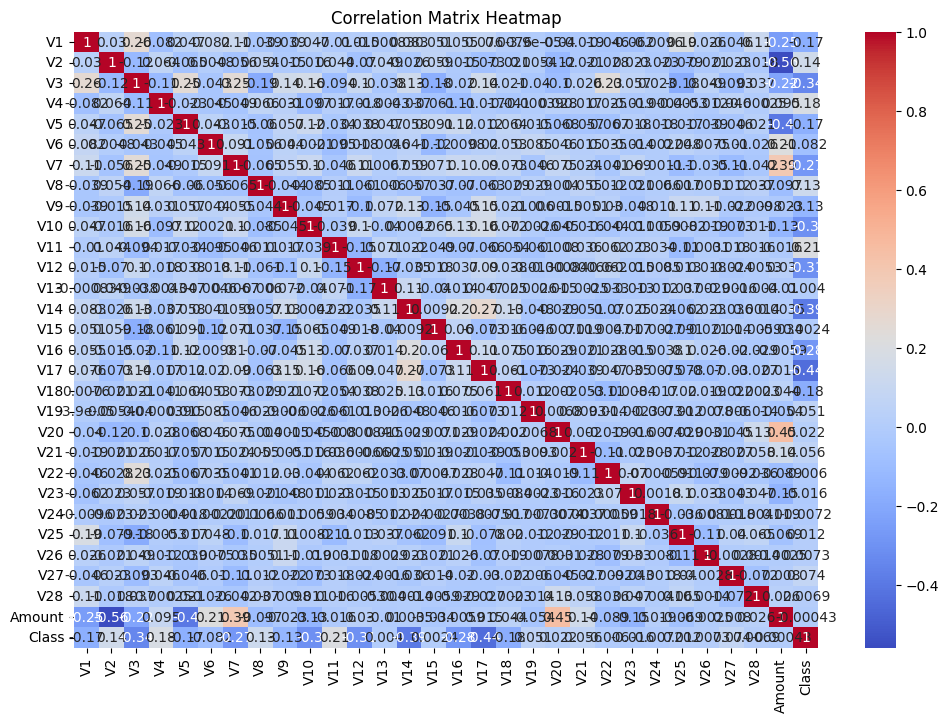

In [15]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [16]:
# Model Architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 30),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# Model Training
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

normal_data_tensor = torch.tensor(normal_data.values, dtype=torch.float32)

num_epochs = 10
loss_values=[]
for epoch in range(num_epochs):
    outputs = model(normal_data_tensor)
    loss = criterion(outputs, normal_data_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 1.2442
Epoch [2/10], Loss: 1.2430
Epoch [3/10], Loss: 1.2418
Epoch [4/10], Loss: 1.2406
Epoch [5/10], Loss: 1.2395
Epoch [6/10], Loss: 1.2383
Epoch [7/10], Loss: 1.2372
Epoch [8/10], Loss: 1.2361
Epoch [9/10], Loss: 1.2349
Epoch [10/10], Loss: 1.2338


In [18]:
# Model Evaluation
test_data = pd.concat([normal_data.sample(frac=0.2), fraudulent_data])
test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

test_outputs = model(test_data_tensor)
test_loss = criterion(test_outputs, test_data_tensor)

print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 1.6608


Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15035
         1.0       0.01      1.00      0.02       183

    accuracy                           0.01     15218
   macro avg       0.01      0.50      0.01     15218
weighted avg       0.00      0.01      0.00     15218



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


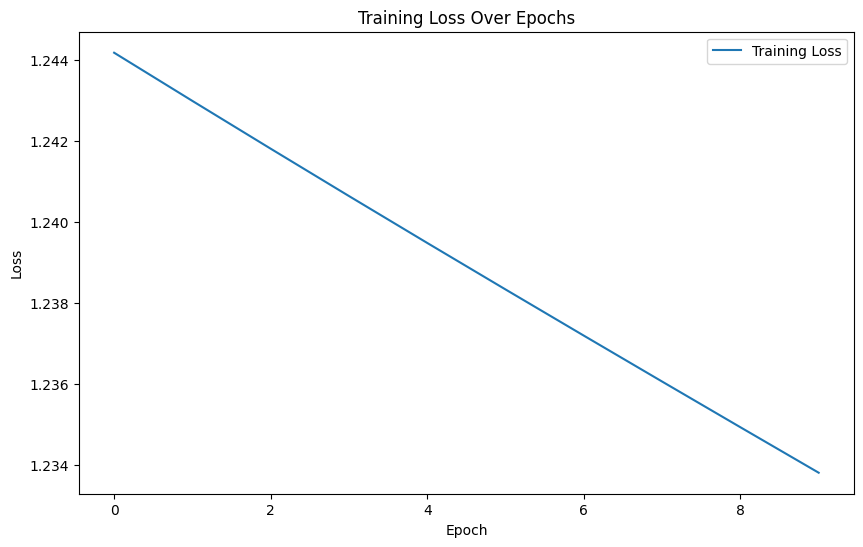

In [19]:
# Classification Report
predicted_labels = [1 if torch.sum((output - data_point)**2).item() > 0.1 else 0 for output, data_point in zip(test_outputs, test_data_tensor)]
true_labels = test_data['Class'].values

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Accuracy vs Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()